In [1]:
%matplotlib inline

import cobra
import numpy as np
import pandas as pd
import seaborn as sns

from importlib_resources import read_text
from matplotlib import pyplot as plt
from typing import List, Tuple, Iterable, Any
from scipy import stats

from pltconfig import *

In [2]:
# Load precomputed flux predictions via pFBA
flux_prediction_df = pd.read_csv('data/FBA/ccmb1_fluxes.csv')
rub_pct_range = (flux_prediction_df.rub_pct_3pg_prod.min(), flux_prediction_df.rub_pct_3pg_prod.max())

# Load precomputed flux inferences (from data).
flux_inference_df = pd.read_csv('data/LCMS/022720_flux_inferrence.csv')
flux_inference_df['pct_12co2_inferred'] = flux_inference_df.f12co2_inferred*100
flux_inference_df['ser_pct12c'] = flux_inference_df.ser_f12c*100

flux_inference_df

,sample,sample_name,ser_f12c,val_f12c,his_f12c,rel_rubisco_3PG_flux,f12co2_inferred,description,pct_12co2_inferred,ser_pct12c
0,AF 1,CAfree_bioreactor,0.004527,0.008098,0.008240,NaN,0.222829,"Control ambient air, bioreactor - CAfree:pFE-s...",22.282937,0.452685
1,AF 2,CAfree_bioreactor,0.008998,0.005226,0.005176,NaN,0.240664,"Control ambient air, bioreactor - CAfree:pFE-s...",24.066412,0.899821
2,AF 3,CAfree_bioreactor,0.003495,0.005430,0.007714,NaN,0.230044,"Control ambient air, bioreactor - CAfree:pFE-s...",23.004394,0.349472
3,AF 4,CAfree_bioreactor,0.007835,0.005119,0.000000,NaN,0.307965,"Control ambient air, bioreactor - CAfree:pFE-s...",30.796546,0.783520
4,AF 5,CCMB1_bioreactor,0.024767,0.012526,0.014273,0.276332,0.409055,Experiment ambient air bioreactor - CCMB1:pCB'...,40.905533,2.476675
5,AF 6,CCMB1_bioreactor,0.028638,0.025383,0.007746,0.149038,0.908982,Experiment ambient air bioreactor - CCMB1:pCB'...,90.898214,2.863817
6,AF 7,CCMB1_bioreactor,0.072608,0.020543,0.000000,0.441850,0.907794,Experiment ambient air bioreactor - CCMB1:pCB'...,90.779382,7.260753
7,AF 8,CCMB1_bioreactor,0.013666,0.008420,0.003346,0.101784,0.445492,Experiment ambient air bioreactor - CCMB1:pCB'...,44.549228,1.366569
8,AF 9,CAfree_10pct_incubator,0.019965,0.011921,0.011318,NaN,0.707723,"Control 10% CO2 incubator, round bottom tube -...",70.772304,1.996484
9,AF 10,CAfree_10pct_incubator,0.027541,0.017212,0.000000,NaN,0.803494,"Control 10% CO2 incubator, round bottom tube -...",80.349431,2.754077


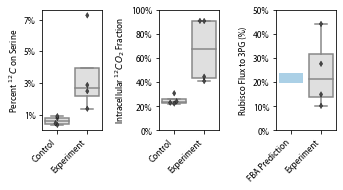

In [6]:
fig = plt.figure(figsize=(7.25, 2.75))
gs = fig.add_gridspec(1, 4, width_ratios=[2.5, 1, 1, 1])

# plot %12C on serine
ax0 = plt.subplot(gs[0, 1])
sns.boxplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[1], showfliers=False)
sns.swarmplot(data=flux_inference_df, x='sample_name', y='ser_pct12c', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax0, color=greys[-2], 
              marker='d', size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(1, 7.1, 2)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],[ 'Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax0.set_ylabel('Percent $^{12}C$ on Serine', fontsize=9)
ax0.set_xlabel('')

# plot inferred 12Ci fraction.
ax1 = plt.subplot(gs[0, 2])
sns.boxplot(data=flux_inference_df, x='sample_name', y='pct_12co2_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[1], showfliers=False)
sns.swarmplot(data=flux_inference_df, x='sample_name', y='pct_12co2_inferred', order=['CAfree_bioreactor', 'CCMB1_bioreactor'], ax=ax1, color=greys[-2], 
              marker='d', size=4, edgecolor='k', linewidth=0.3)

yticks = np.arange(0, 101, 20)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1], ['Control', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax1.set_xlabel('')
ax1.set_ylabel('Intracellular $^{12}CO_2$ Fraction', fontsize=9)


# Estimated flux through rubisco as compared to FBA predictions
ax2 = plt.subplot(gs[0, 3])

inferred_rub_flux = (flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor'].rel_rubisco_3PG_flux*100).values.tolist()
n_exps = len(inferred_rub_flux)

# TODO - actually use prediction here.
width = 0.8
xy = (-width/2, rub_pct_range[0])
height = rub_pct_range[1] - rub_pct_range[0]
fba_rect = plt.Rectangle(xy, width, height, facecolor=blues[2])
ax2.add_patch(fba_rect)

sns.boxplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[1], showfliers=False)
sns.swarmplot(x=[1]*n_exps, y=inferred_rub_flux, order=[0, 1], ax=ax2, color=greys[-2],
              marker='d', size=4, edgecolor='k', linewidth=0.3)

#plt.scatter([1]*n_exps, inferred_rub_flux, marker='d', s=12, color=greys[-2])
#sns.swarmplot(x=[1]*4, y=inferred_rub_flux, ax=ax2, color=greys[-2], marker='d')

yticks = np.arange(0, 51, 10)
plt.yticks(yticks, ['%d%%' % y for y in yticks], fontsize=9)
plt.xticks([0, 1],['FBA Prediction', 'Experiment'], fontsize=9, rotation=45, ha='right')
ax2.set_ylabel('Rubisco Flux to 3PG (%)', fontsize=9)
ax2.set_xlabel('')
ax2.set_ylim(0, 50)
ax2.set_xlim(-0.5, 1.5)

plt.tight_layout()
plt.savefig('figS8/figS8.png', dpi=300)
plt.show()

In [10]:
exps = flux_inference_df[flux_inference_df.sample_name == 'CCMB1_bioreactor']
mean_exp = exps.rel_rubisco_3PG_flux.mean() * 100
std_exp = exps.rel_rubisco_3PG_flux.std() * 100
print('Mean rubisco flux fraction %.1f%% +/- %.1f%%' % (mean_exp, std_exp))

Mean rubisco flux fraction 24.2% +/- 15.2%
